In [4]:
import zipfile
from pathlib import Path

from IPython.display import Image, display, display_png

from mglyph_ml.dataset.glyph_dataset import GlyphDataset
from mglyph_ml.dataset.manifest import DatasetManifest, ManifestSample
from mglyph_ml.experiment.e1.experiment import ExperimentConfig, run_experiment

config = ExperimentConfig(
    task_name="Experiment 1.2.1",
    task_tag="exp-1.2.1",
    dataset_path="data/universal.mglyph",
    gap_start_x=40.0,
    gap_end_x=60.0,
    quick=True,
    seed=420,
    max_iterations=5,
    offline=True,
)

In [5]:
from concurrent.futures import ThreadPoolExecutor
from zipfile import ZipFile

import cv2
import numpy as np

path = Path("../data/universal.mglyph")


def decode_png_bytes(png_bytes: bytes) -> np.ndarray:
    buf = np.frombuffer(png_bytes, dtype=np.uint8)
    img = cv2.imdecode(buf, cv2.IMREAD_COLOR)  # HWC, BGR, uint8
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def load_image_into_ndarray(archive: ZipFile, filename: str) -> np.ndarray:
    png_bytes = archive.read(filename)
    return decode_png_bytes(png_bytes)

In [11]:
# loading everything... this cell takes the longest time

temp_archive = zipfile.ZipFile(path, "r")

manifest_data = temp_archive.read("manifest.json")
manifest = DatasetManifest.model_validate_json(manifest_data)

samples_all = manifest.samples["uni"]

# Create index mappings for each subset
train_indices = [i for i, sample in enumerate(samples_all) if sample.x < 40.0 or sample.x >= 60]
gap_indices = [i for i, sample in enumerate(samples_all) if sample.x >= 40.0 and sample.x < 60]
test_indices = list(range(len(samples_all)))

# Get sample subsets using indices
manifest_samples_train: list[ManifestSample] = [samples_all[i] for i in train_indices]
manifest_samples_gap: list[ManifestSample] = [samples_all[i] for i in gap_indices]
manifest_samples_test: list[ManifestSample] = samples_all

# Load all images once
with ThreadPoolExecutor(max_workers=64) as executor:
    images_all = list(
        executor.map(lambda sample: load_image_into_ndarray(temp_archive, sample.filename), samples_all)
    )

# Reference image subsets using indices
images_train = [images_all[i] for i in train_indices]
images_gap = [images_all[i] for i in gap_indices]
images_test = images_all

labels_train = [samples_all[i].x for i in train_indices]
labels_gap = [samples_all[i].x for i in gap_indices]
labels_test = [sample.x for sample in samples_all]

temp_archive.close()

Number of images: 12039
First image type: <class 'numpy.ndarray'>
First image dtype: uint8
First image shape: (512, 512, 3)
First image is ndarray: True
First image in BGR format: True


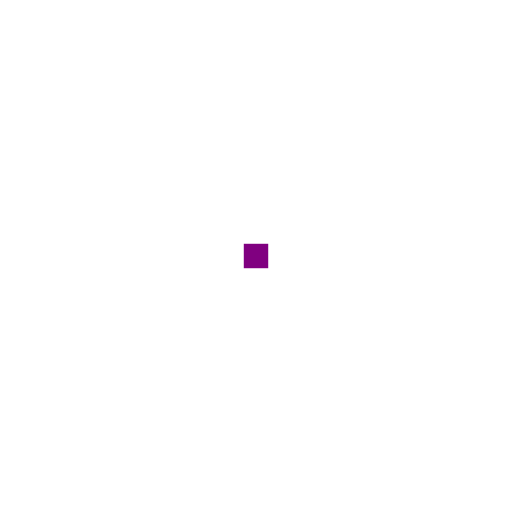

In [12]:
# Verify BGR format and display sample image
print(f"Number of images: {len(images_train)}")
print(f"First image type: {type(images_train[0])}")
print(f"First image dtype: {images_train[0].dtype}")
print(f"First image shape: {images_train[0].shape}")
print(f"First image is ndarray: {isinstance(images_train[0], np.ndarray)}")
print(f"First image in BGR format: {images_train[0].dtype == np.uint8 and len(images_train[0].shape) == 3}")

# Display one sample image (convert BGR to RGB for display)
display_img = cv2.cvtColor(images_train[0], cv2.COLOR_BGR2RGB)
display(Image(data=cv2.imencode('.png', display_img)[1].tobytes()))

In [13]:
dataset_train = GlyphDataset(images=images_train, labels=labels_train, transform=None)